# Protected Moonshot Vault Impovement Proposal - 001

## Core idea

The properties of options appear to fit naturally into our Protected Moonshot Vault strategy (link VIP post). This notebook aims to analyse the strategy returns when using options as the derivative product used to make the weekly leveraged bets.

The notebook is structured as follows: First, the relevant data required for backtesting an option strategy is imported and its suitability analysed. Then the performance of a simple option buying strategy is compared to our existing perpetual strategy. The key drivers of returns are then investigated which guide some strategy improvements. Finally these improved strategies are compared and contrasted to the base strategies and conclusion are presented. 

## Implementation

### Imports

In [1]:
import time
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

import utils
from option_utils import blackScholesPrice, runOptionBacktest
from perp_utils import runPerpBacktest, checkPerpExit
sns.set(palette='deep')

### Data

For this proposal chosen data consists of:
 * Hourly and weekly ETH DVOL obtained from Deribit
 * FTX price data
 * 1-week at-the-money ETH implied volatility data

In [2]:
#deribit DVOL historical data
dvol_raw = pd.read_csv("data/deribitETH_DVOL_1609452000_1646863200.csv")
dvol_raw = dvol_raw.iloc[24*2:,:] #start data on Friday

hourly_dvol,weekly_dvol = utils.dvolTransformer(dvol_raw)

#FTX price data
ftx_raw = pd.read_csv("data/ftx_PriceDataETH-PERP_1614906000_1646645961.csv")
ftx_raw = ftx_raw[ (pd.to_datetime(ftx_raw.startTime)>=hourly_dvol.index[0])
                  & (pd.to_datetime(ftx_raw.startTime)<=hourly_dvol.index[-1]) ]

hourly_data,weekly_data = utils.ftxTransformer(ftx_raw)


#ETH 1week atm IV data
skew_data_raw = pd.read_csv("data/skew_eth_atm_implied_volatility.csv")
skew_data_raw = skew_data_raw[ (pd.to_datetime(skew_data_raw.DateTime,utc=True)>=hourly_dvol.index[0])  & (pd.to_datetime(skew_data_raw.DateTime,utc=True)<=hourly_dvol.index[-1]) ]
hourly_skew_data,weekly_skew_data = utils.skewDataTransformer(skew_data_raw)

### Deeper Analysis of Implied Volatility Data

In order to backtest any option strategy, one needs historical implied volatility data. 

We examine two sources, _Deribit ETH DVOL_ volatility index and _1week atm ETH Implied Volatility_ data. 
Our goal is to compare and access whether the two exibit similar behaviour and are suitable to use in our strategy.

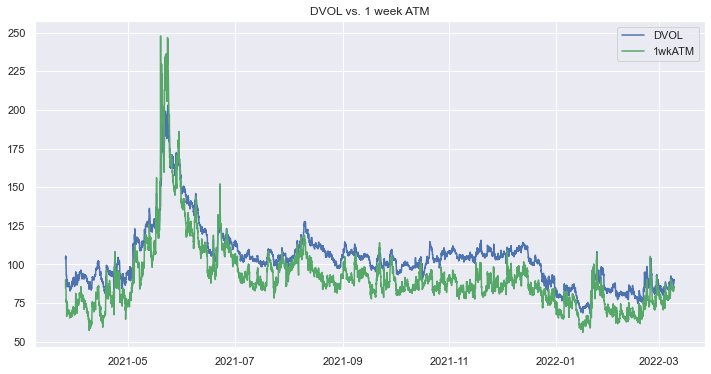

In [3]:
#Plot compare DVOL and 1weekATM implied volatilities
plt.figure(figsize=(12,6))

plt.plot(hourly_dvol.dvol_close,color='b')
plt.plot(hourly_skew_data.close,color='g')
plt.title('DVOL vs. 1 week ATM')
plt.legend(['DVOL','1wkATM'])
plt.show()

DVOL is a VIX-like volatility index and uses a variance swap-like formula i.e. it takes into account the implied volatility of the entire skew. 

Since ETH options tend to trade on a smile** we expect DVOL to typically be higher than the current ATM IV, which is supported by the behaviour shown in the chart. Hence, it can also be considered a fear-measure.

We therefore stick to using 1week ATM implied volatility data for our testing of option based strategies since this will give a better indication of where close to atm options can be purchased and sold at a point in time
___
_*Trading on a smile_ means that otm put and call iv's are higher than atm iv's





### Additional data processing

For our momentum strategy we need to additionaly generate the simple moving average(SMA) on daily data and then combine all availiable information in a weekly dataframe.

The chosen hyperparameter for our model is the SMA window size. For the current example we assume the window size of 5 days based on the empirical experience.

In [4]:
#Create Additional Required Data
#Generate data and then add to weeklyData Dataframe (the central price data input)

#Simple Moving Average

window = '5d'

#Calculating the moving average for vectorised momentum signal calculation
daily_data = hourly_data.close.resample('1d',offset = '8h',label='right').last()
moving_avg = daily_data.rolling(window).mean().shift().rename('movingAvg')

weekly_data['moving_avg'] = moving_avg.resample('7d', offset='8h',label='left').first().shift()


# Calculating the realised volatility
rv = (np.log(1+daily_data.pct_change()).rolling('7d').std()*np.sqrt(365)).rename('realised_volatilty')

#Resampling the realised volality of the precending 7days
weekly_rv = rv.resample('7d', offset='8h',label='left').first()

#dates in weeklyData DF are the weekly EndDates
weekly_data['realised_vol_end'] = weekly_rv
#shifting weeklyRV gives us the Realised Volatility of the 7days precending the start of the week
weekly_data['realised_vol_start'] = weekly_rv.shift() 

#drop first week, not a full week 
weekly_data.drop(index=weekly_data.index[0], 
        axis=0, 
        inplace=True)


### Backtest

Currently the Protected Moonshot Vault runs an _enhanced_* perpetual future strategy .
The primary goal of our backtest is to compare the the existing perp strategy perfomance, both simple and enhanced variations, to that of the proposed option strategy. 

For the sake of consistency we keep our signalling logic the same as it is currently for perp strategies - a momentum signal based on a simple moving average. 
We do so to avoid ambiguity in the interpretation of the relationships between our proposed impovements and the strategies perfomace. 

___
_*Enhanced_ here means the addition of the continuously monitored "take profit" and "stop loss" levels

In [5]:
# Perp Strategy specific params
leverage = 8.0
mm_min = 0.0625 # maintanence margin required for perp protocol
take_profit = 0.20 # take profit for enhanced strat
stop_loss = 0.05 # stop loss for enhanced strat

# Option Strategy specific params
r = 0 # r used in option pricing formula
strike_rounding = True # whether to apply rounding to option strikes
otm_percentage = 0 # % OTM of strike to buy/sell
bid_offer_spread = 5.0 # IV data is mid volatilities, add vol spread to get traded vol


# General Parameters
capital = 100 # starting capital
stables_yield = 0.12 # convex deposit yield
freq = 7 # interest harvest and trade frequency (days)
interest = capital*stables_yield*freq/365

data_store = pd.DataFrame()

signal_choice = ['100% Accurate','Momentum strategy']

for strat in signal_choice:

    # Determine weekly strategy position
    # 1: bullish trade
    # -1: bearish trade
    if strat == '100% Accurate':
        weekly_data['position'] = np.where(weekly_data.price_change>0,1,-1) #see the future
    elif strat == 'Momentum strategy':
        weekly_data['position'] = np.where(weekly_data.open > weekly_data.moving_avg,1,-1)

    
    # Run simple and enhanced strategies on perps
    perp_simple, perp_alpha = runPerpBacktest(weekly_data,hourly_data,freq,leverage,mm_min,interest,'USD','simple')
    perp_enhanced, perp_alpha_enhanced = runPerpBacktest(weekly_data,hourly_data,freq,leverage,mm_min,interest,'USD','enhanced',take_profit,stop_loss)

    # Run the strategies for options
    option_buy,option_buy_alpha = runOptionBacktest(weekly_data,weekly_skew_data+bid_offer_spread/2,freq,interest,'USD',r,otm_percentage,'optionBuyer',strike_rounding)
    
    # Calculate the position accuracy relative to the movement of the market
    accuracy = ((weekly_data.position * weekly_data.price_change) > 0 ).sum() / weekly_data.shape[0]
    
    # Data aggregation
    store = pd.DataFrame.from_dict({'Overall Signal Accuracy:':accuracy,'Simple Perp Strategy:':perp_alpha,'Enhanced Perp Strategy:':perp_alpha_enhanced,'Long Option Strategy:':option_buy_alpha},orient='index')   
    store.rename(columns={0:strat},inplace=True)
    data_store = pd.concat([data_store,store],axis=1)

For both perp and option strategies the trading Alpha APR% denominated in USD.

The two signalling logics chosen for comparison are the _100% accuracy_ and the _simple momentum_ signal. By 100% accuracy we mean the choosing the perfect positions at every given time.

Results are shown for a base stablecoin yield of 12%. 

In [6]:
display(round(data_store,2))

,100% Accurate,Momentum strategy
Overall Signal Accuracy:,1.00,0.61
Simple Perp Strategy:,5.14,-0.86
Enhanced Perp Strategy:,7.34,2.77
Long Option Strategy:,13.14,2.80


We note that the option strategy significantly outperforms the enhanced perp strategy when our signal is 100% accurate resulting in more than 2x improvement in the APR. When using our momentum signal we see similar performance for both strategy with the base APR improved by 1.25x. 

Its clear that the option strategy has potential for outsized gains however incorrect signal direction is more costly for the option strategy as the weekly premium paid is forfeited. 

Lets investigate further improvements to the option strategy:

### Weekly Option Return Analysis

We examine the weekly trading returns plotted against various metrics such as the weekly asset price move, the ATM implied volatility as well as the current difference between DVOL and realised volatility.

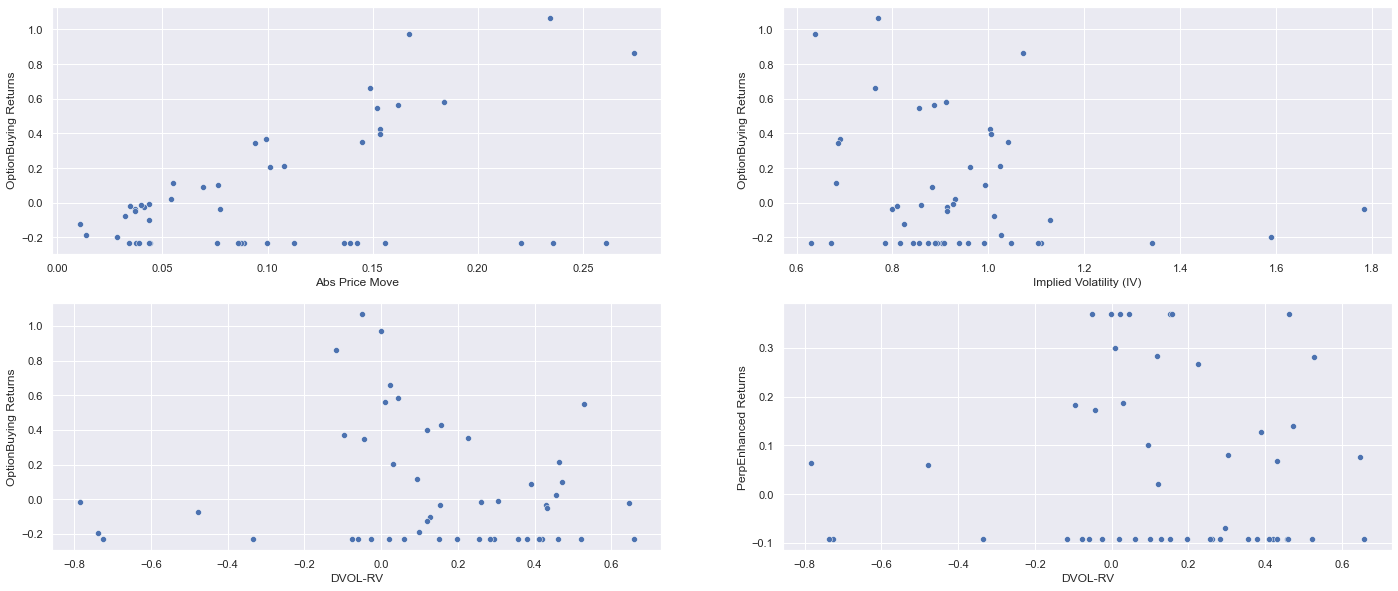

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,10))

# Plotting the absolute price move against the option buying strategy returns
sns.scatterplot(x=abs(weekly_data.price_change), y=option_buy.optionReturns, ax=axes[0,0]);
axes[0,0].set_xlabel('Abs Price Move');
axes[0,0].set_ylabel('OptionBuying Returns');

# Plotting the Implied Volatility (IV) against the option buying strategy returns
sns.scatterplot(x=option_buy.sigma_open, y=option_buy.optionReturns, ax=axes[0,1]);
axes[0,1].set_xlabel('Implied Volatility (IV)');
axes[0,1].set_ylabel('OptionBuying Returns');

# Plotting the DVOL-RV against the option buying strategy returns
sns.scatterplot(x=weekly_dvol.iloc[1:,:].dvol_open/100 - weekly_data.realised_vol_start, y=option_buy.optionReturns, ax=axes[1,0]);
axes[1,0].set_xlabel('DVOL-RV');
axes[1,0].set_ylabel('OptionBuying Returns');

# Plotting the DVOL-RV against the enhanced perp strategy returns
sns.scatterplot(x=weekly_dvol.iloc[1:,:].dvol_open/100 - weekly_data.realised_vol_start, y=perp_enhanced.perpReturns, ax=axes[1,1]);
axes[1,1].set_xlabel('DVOL-RV');
axes[1,1].set_ylabel('PerpEnhanced Returns');


We take particular interest in the second row of charts showing weekly trading returns vs the difference of DVOL and realised volalitity. For the option strategy, postive returns are clustered in middle of the (DVOL - Realised Volality) x-axis. 

On the right hand side we have areas where DVOL (a average measure of average option IVs) is much higher than realised volatility. One can say options are expensive in these areas as the market needs to move significantly more than it has been in order to just recover the option premium. In these weeks purchasing options may not be the best trade

On the left hand side we have areas where realised volatility is higher than implied volatilities - typically this means the market has just had some very large moves.In these areas it makes sense that our momentum signal will perform poorly since the market is not trending in one direction but rather having large fluctuations. In weeks when we have less confidence in our signal we rather not trade options given the possibility of losing the entire interest amount.

We note that the current perpetual strategy returns do not exhibit the same extent of clustering.

We then try 3 improved strategies.
1. In weeks where the DVOL premium is an outlier we don't take any trade, in all other weeks we purchase options (Options V2.0)

2. In weeks where the DVOL premium is an outlier we don't take any trade, in all other weeks we use our current perp strategy (Perp Imprv 2.0)

3. In weeks where the DVOL premium is an outlier we use our current perp strategy, in all other weeks we purchase options (Options+Perp)


In [10]:
combined_strats = pd.concat([weekly_data[['price_change','position']]
                          ,perp_enhanced['perpReturns']
                          ,option_buy[['optionReturns','sigma_open']]
                          ,weekly_data.realised_vol_start
                          ,weekly_dvol.dvol_open/100]
                        ,axis=1)


combined_strats['iv_premium'] = combined_strats['dvol_open']-combined_strats['realised_vol_start']

# We define a threshold were IV significantly varies from DVOL
dvol_premium_threshold = 0.20

mask_iv_prem_outlier = (combined_strats['iv_premium'] > dvol_premium_threshold) | (combined_strats['iv_premium'] < -dvol_premium_threshold)


# Implementing the first idea, when DVOL in range purchase options, otherwise do no not enter an option trade
combined_strats['optionsV2_0'] = np.where( mask_iv_prem_outlier,0,combined_strats['optionReturns'])

# Implementing the second idea, when DVOL in range current perp strategy otherwise do no not enter a perp trade
combined_strats['perpV2_0'] = np.where( mask_iv_prem_outlier,0,combined_strats['perpReturns'])

# Implementing the third idea, when DVOL in range purchase options, otherwise use perp strategy
combined_strats['options_perp'] = np.where( mask_iv_prem_outlier,combined_strats['perpReturns'],combined_strats['optionReturns'])


num_weeks = combined_strats.shape[0]
optionV2_0_alpha = combined_strats.optionsV2_0.sum() / (num_weeks/52)
option_perp_alpha = combined_strats.options_perp.sum() / (num_weeks/52)
perpV2_0_alpha = combined_strats.perpV2_0.sum() / (num_weeks/52)

__IMPROVED STRATEGY RESULTS:__

Trading Alpha APR% denominated in USD.

Results are obtained using a base Yield of 12% 

In [11]:
print("Perp Imprv     {a:2.2f}%".format(a=perp_alpha_enhanced))
print("OptionBuy      {a:2.2f}%\n".format(a=option_buy_alpha))
print("OptionV2.0     {a:2.2f}%".format(a=optionV2_0_alpha))
print("Perp Imprv2.0  {a:2.2f}%".format(a=perpV2_0_alpha))
print("Options+Perp   {a:2.2f}%".format(a=option_perp_alpha))

Perp Imprv     2.77%
OptionBuy      2.80%

OptionV2.0     4.68%
Perp Imprv2.0  2.63%
Options+Perp   4.76%


__IMPROVED STRATEGY RETURN PLOTTING:__


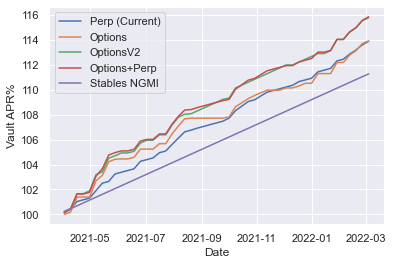

In [13]:
plt.plot((perp_enhanced.perpReturns+interest).cumsum()+capital)
plt.plot((option_buy.optionReturns+interest).cumsum()+capital)
plt.plot((combined_strats.optionsV2_0+interest).cumsum()+capital)
plt.plot((combined_strats.options_perp+interest).cumsum()+capital)
plt.plot((abs(combined_strats.position)*interest).cumsum()+capital)
plt.ylabel('Vault APR%')
plt.xlabel('Date')
plt.legend(['Perp (Current)','Options','OptionsV2','Options+Perp','Stables NGMI'])
plt.show()


Adjusting the option strategy in weeks where the DVOL premium is outside our range provides promising results. 

Doing nothing in those weeks gives similar results to executing perpetual future trades in those weeks. Importantly we are able to signficantly improve the trading alpha by using options in our weekly trading strategy which provides a 1.4x boost to the underlying yield.  

## Conclusion

The integration of an options trading venue such as Lyra may improve the protected moonshot vault returns given the properties of derivatives. 